In [2]:
import numpy as np 
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d 
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from scipy.interpolate import Rbf

## Calculate Arclength

In [3]:
def arc_length(x, y, z):
    npts = len(x)
    arc = np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2+ (z[1] - z[0])**2)
    for k in range(1, npts):
        arc = arc + np.sqrt((x[k] - x[k-1])**2 + (y[k] - y[k-1])**2+ (z[k] - z[k-1])**2)

    return arc

## Generate difference vector (for the estimation)

In [4]:
def generateVector(x0, x1, timestep):
  return (x1 - x0) / timestep 

## Nonlinear Approximation

In [5]:
def radialFunction(center, X, eps):
  return np.exp(-euclidean_distances(X, [center]) ** 2 / eps ** 2)

def radialBase(num_basis, X):
  centers = np.random.RandomState(seed=42).permutation(len(X))[:num_basis]
  return X[centers]

def radialBasis(base, X, eps):
  test = []
  for center in base:
    test.append(radialFunction(center, X, eps))
  test = np.asarray(test)
  return test.T[0]

def approxNonLinear(X, Y, num_basis, eps):
  
  base = radialBase(num_basis, X)
  radial_functions = radialBasis(base, X, eps)

  return np.linalg.lstsq(radial_functions, Y, rcond=None)[0].T, base

def findNumCenters(x0, vec, timestep, x):
  # Tune the number of centers
  search = np.linspace(2000, 3000, 20)[:-1]
  eps = 0.0001
  best = 0.1, np.inf, None, None
  for center_num in search:
    coeff, base = approxNonLinear(x0.reshape((-1,1)), vec, int(center_num), eps)
    err = mse(x, x0 + radialBasis(base, x0.reshape((-1,1)), eps) @ coeff.T * timestep)

    if err < best[1]:
      best = int(center_num), err, coeff, base
  
  return best

## Callables for the equations to be solved by the solve_ivp

In [15]:
def nonlinStepFunc(t, x0):
    eps = 0.001
    return (radialBasis(best[3], x0.reshape(-1,1), eps) @ best[2].T).reshape(-1) 

## Calculate MSE

In [6]:
def mse(real_data, predicted_data):
  return np.linalg.norm(real_data - predicted_data) ** 2 / len(real_data)

In [7]:
# Loading the data in numpy array and ignoring first 1000 rows
data = np.loadtxt("MI_timesteps.txt.txt",skiprows=1001)

In [8]:
# Creating data set of M points of 1053 dimensions
# Reading the first 3000 points only (a bit more than a day)
# This should be enough since the data is periodic

for i in range(data.shape[0]-351):
    data_window = data[i:i+351,1:4]
    flattened_data_window = data_window.flatten()
    if i==0:
        timestep=flattened_data_window
    else:
        timestep = np.vstack((timestep, flattened_data_window) )
    if i > 3000:
        break



In [9]:
print(timestep.shape)

(3002, 1053)


In [10]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(timestep)
print(principalComponents.shape)

(3002, 3)


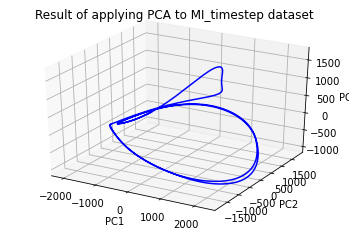

In [11]:
fig = plt.figure() 
  
# syntax for 3-D projection 
ax = plt.axes(projection ='3d')
# plotting 
ax.plot3D(principalComponents[:,0],principalComponents[:,1],principalComponents[:,2], 'blue') 
ax.set_title('Result of applying PCA to MI_timestep dataset') 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.savefig("PCA_result.png")
plt.show()

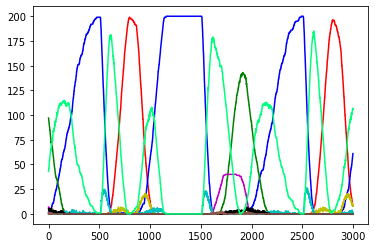

In [12]:
time = [i for i in range(3000)]
c1 = data[0:3000,1]
c2 = data[0:3000,2]
c3 = data[0:3000,3]
c4 = data[0:3000,4]
c5 = data[0:3000,5]
c6 = data[0:3000,6]
c7 = data[0:3000,7]
c8 = data[0:3000,8]
c9 = data[0:3000,9]
plt.plot(time, c1, c='r')
plt.plot(time, c2, c='b')
plt.plot(time, c3, c='g')
plt.plot(time, c4, c='m')
plt.plot(time, c5, c='y')
plt.plot(time, c6, c='c')
plt.plot(time, c7, c='k')
plt.plot(time, c8, c='tab:brown')
plt.plot(time, c9, c='springgreen')


In [13]:
arclengths = []
for i in range(principalComponents.shape[0]-1):
    x = [principalComponents[i][0],principalComponents[i+1][0]]
    y = [principalComponents[i][1],principalComponents[i+1][1]]
    z = [principalComponents[i][2],principalComponents[i+1][2]]
    arclengths.append(arc_length(x, y, z))

In [14]:
x0 = arclengths[0:len(arclengths)-1]
x1 = arclengths[1:len(arclengths)]
vec = generateVector(np.asarray(x0), np.asarray(x1), 1)
best = findNumCenters(np.asarray(x0), vec, 1, np.asarray(x1))

In [16]:
print("Error = "+str(best[1]))
print("Best number of centers = "+str(best[0]))

Error = 0.0005231257893702345
Best number of centers = 2947


In [17]:
x_utils = (x0 + radialBasis(best[3], np.asarray(x0).reshape((-1,1)), 0.0001) @ best[2].T * 1)

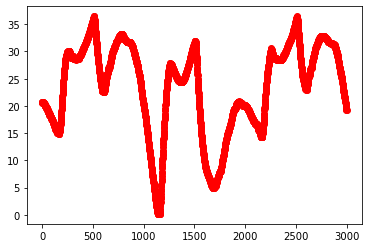

In [19]:
time = [i for i in range(3000)]

plt.scatter(time, x1, c = 'r')

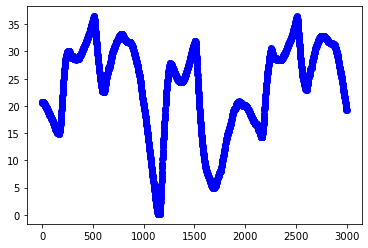

In [20]:
plt.scatter(time, x_utils, c='b')